In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import shutil


if '/home/shantanu.singh/indoor-layout-estimation' not in sys.path:
    sys.path.append('/home/shantanu.singh/indoor-layout-estimation')

In [29]:
kitti_odom_to_raw_map = '''00: 2011_10_03_drive_0027 000000 004540
01: 2011_10_03_drive_0042 000000 001100
02: 2011_10_03_drive_0034 000000 004660
03: 2011_09_26_drive_0067 000000 000800
04: 2011_09_30_drive_0016 000000 000270
05: 2011_09_30_drive_0018 000000 002760
06: 2011_09_30_drive_0020 000000 001100
07: 2011_09_30_drive_0027 000000 001100
08: 2011_09_30_drive_0028 001100 005170
09: 2011_09_30_drive_0033 000000 001590
10: 2011_09_30_drive_0034 000000 001200'''

scene_rows = kitti_odom_to_raw_map.split('\n')
scene_map = {}
for idx in range(len(scene_rows)):
    row_data = scene_rows[idx].split()
    scene_map[row_data[0][:2]] = [row_data[1], int(row_data[2]), int(row_data[3])]
    
scene_map

{'00': ['2011_10_03_drive_0027', 0, 4540],
 '01': ['2011_10_03_drive_0042', 0, 1100],
 '02': ['2011_10_03_drive_0034', 0, 4660],
 '03': ['2011_09_26_drive_0067', 0, 800],
 '04': ['2011_09_30_drive_0016', 0, 270],
 '05': ['2011_09_30_drive_0018', 0, 2760],
 '06': ['2011_09_30_drive_0020', 0, 1100],
 '07': ['2011_09_30_drive_0027', 0, 1100],
 '08': ['2011_09_30_drive_0028', 1100, 5170],
 '09': ['2011_09_30_drive_0033', 0, 1590],
 '10': ['2011_09_30_drive_0034', 0, 1200]}

In [24]:
dict([(k, os.path.join(v[0] + '_sync', 'proj_depth', 'groundtruth')) for k,v in scene_map.items()])

{'00': '2011_10_03_drive_0027_sync/proj_depth/groundtruth',
 '01': '2011_10_03_drive_0042_sync/proj_depth/groundtruth',
 '02': '2011_10_03_drive_0034_sync/proj_depth/groundtruth',
 '03': '2011_09_26_drive_0067_sync/proj_depth/groundtruth',
 '04': '2011_09_30_drive_0016_sync/proj_depth/groundtruth',
 '05': '2011_09_30_drive_0018_sync/proj_depth/groundtruth',
 '06': '2011_09_30_drive_0020_sync/proj_depth/groundtruth',
 '07': '2011_09_30_drive_0027_sync/proj_depth/groundtruth',
 '08': '2011_09_30_drive_0028_sync/proj_depth/groundtruth',
 '09': '2011_09_30_drive_0033_sync/proj_depth/groundtruth',
 '10': '2011_09_30_drive_0034_sync/proj_depth/groundtruth'}

In [25]:
root_dir = '/scratch/shantanu.singh/kitti'
os.listdir(root_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/shantanu.singh/kitti'

In [5]:
depth_dir = os.path.join(root_dir, 'kitti_depth')
os.listdir(depth_dir)

['train', 'val', 'data_depth_annotated.zip']

In [6]:
scene_dir = os.path.join(depth_dir, 'train', scene_map['00'][0] + '_sync', 'proj_depth', 'groundtruth', 'image_02')
os.listdir(scene_dir)[:5]

['0000000394.png',
 '0000004207.png',
 '0000003875.png',
 '0000001844.png',
 '0000003771.png']

In [7]:
train_scenes = os.listdir(os.path.join(depth_dir, 'train'))
for scene in scene_map:
    scene_dir = scene_map[scene][0] + '_sync'
    if scene_dir not in train_scenes:
        print(scene, scene_dir)

03 2011_09_26_drive_0067_sync
04 2011_09_30_drive_0016_sync


In [26]:
del scene_map['03']
del scene_map['04']

In [9]:
color_dir = os.path.join(root_dir, 'dataset', 'sequences')

In [10]:
os.listdir(os.path.join(root_dir, 'dataset', 'sequences', '01', 'image_2'))[:5]

['000274.png', '000057.png', '000985.png', '000200.png', '000418.png']

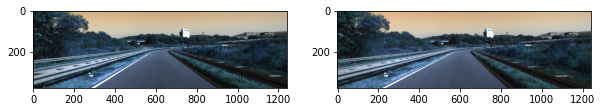

In [11]:
fileidx = '000985'
img_path = os.path.join(root_dir, 'dataset', 'sequences', '01', '{}', f'{fileidx}.png')

fig,ax = plt.subplots(ncols=2, figsize=(10, 6))
ax[0].imshow(cv2.imread(img_path.format('image_2'), -1))
ax[1].imshow(cv2.imread(img_path.format('image_3'), -1))
plt.show()

In [12]:
os.listdir(os.path.join(root_dir, 'dataset', 'poses'))

['06.txt',
 '01.txt',
 '00.txt',
 '03.txt',
 '05.txt',
 '07.txt',
 '10.txt',
 '02.txt',
 '09.txt',
 '08.txt',
 '04.txt']

In [13]:
# Read and parse the poses
pose_file = os.path.join(root_dir, 'dataset', 'poses', '01.txt')
poses = []
with open(pose_file, 'r') as f:
    lines = f.readlines()

    for line in lines:
        T_w_cam0 = np.fromstring(line, dtype=float, sep=' ')
        T_w_cam0 = T_w_cam0.reshape(3, 4)
        T_w_cam0 = np.vstack((T_w_cam0, [0, 0, 0, 1]))
        poses.append(T_w_cam0)
            
poses = np.array(poses)
poses.shape

(1101, 4, 4)

In [14]:
poses[10]

array([[ 0.8965559 , -0.01307765,  0.4427376 ,  2.488685  ],
       [ 0.0234179 ,  0.9995655 , -0.01789659, -0.3309237 ],
       [-0.4423112 ,  0.02641328,  0.8964725 ,  9.527392  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [15]:
def read_calib_file(filepath):
    """Read in a calibration file and parse into a dictionary."""
    data = {}

    with open(filepath, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

In [16]:
os.listdir(os.path.join(root_dir, 'dataset', 'sequences', '00'))

['image_3', 'image_2', 'calib.txt', 'times.txt']

In [17]:
scene_map

{'00': ['2011_10_03_drive_0027', 0, 4540],
 '01': ['2011_10_03_drive_0042', 0, 1100],
 '02': ['2011_10_03_drive_0034', 0, 4660],
 '05': ['2011_09_30_drive_0018', 0, 2760],
 '06': ['2011_09_30_drive_0020', 0, 1100],
 '07': ['2011_09_30_drive_0027', 0, 1100],
 '08': ['2011_09_30_drive_0028', 1100, 5170],
 '09': ['2011_09_30_drive_0033', 0, 1590],
 '10': ['2011_09_30_drive_0034', 0, 1200]}

In [23]:
baseline = []
K = []
t2 = []
t3 = []
for scene in scene_map.keys():
    calib = read_calib_file(os.path.join(root_dir, 'dataset', 'sequences', scene, 'calib.txt'))
    P0 = calib['P0'].reshape((3,4))
    K_inv = np.linalg.inv(P0[:3, :3])
    T0C = K_inv @ P0
    T0C = np.vstack([T0C, np.array([0, 0, 0, 1])])
    TC0 = np.linalg.inv(T0C)
    
    P2 = calib['P2'].reshape((3,4))
    K.append(P2[:3, :3])
    K_inv = np.linalg.inv(P2[:3, :3])
    T2C = K_inv @ P2
    T2C = np.vstack([T2C, np.array([0, 0, 0, 1])])
    TC2 = np.linalg.inv(T2C)
    t2.append(T2C @ TC0 @ np.array([0,0,0,1]))
    

    P3 = calib['P3'].reshape((3,4))
    K.append(P3[:3, :3])
    K_inv = np.linalg.inv(P3[:3, :3])
    T3C = K_inv @ P3
    T3C = np.vstack([T3C, np.array([0, 0, 0, 1])])
    TC3 = np.linalg.inv(T3C)
    t3.append(T3C @ TC0 @ np.array([0,0,0,1]))

    T32 = T3C @ TC2
    baseline.append(T32 @ np.array([0, 0, 0, 1]))

In [32]:
TC3

array([[ 1.        ,  0.        ,  0.        ,  0.47441838],
       [ 0.        ,  1.        ,  0.        , -0.00187031],
       [ 0.        ,  0.        ,  1.        , -0.0033185 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [30]:
np.mean(np.stack(baseline)[:, 0])

-0.5347296216763723

In [25]:
np.stack(K).mean(axis=0)

array([[711.0128    ,   0.        , 603.6558    ],
       [  0.        , 711.0128    , 183.81216667],
       [  0.        ,   0.        ,   1.        ]])

In [26]:
np.stack(t2).mean(axis=0)

array([ 0.06066658, -0.00133688,  0.0053954 ,  1.        ])

In [27]:
np.stack(t3).mean(axis=0)

array([-0.47406304,  0.00192326,  0.00385074,  1.        ])

# Kitti dataset split

In [34]:
root_dir = '/scratch/shantanu/kitti'
os.listdir(root_dir)

['results',
 'data_depth_annotated.zip',
 'odometry',
 'data_odometry_poses.zip',
 'dataset',
 'data_odometry_color.zip']

In [8]:
odom_to_raw_map = {
    '00': '2011_10_03_drive_0027_sync/proj_depth/groundtruth',
    '01': '2011_10_03_drive_0042_sync/proj_depth/groundtruth',
    '02': '2011_10_03_drive_0034_sync/proj_depth/groundtruth',
    '05': '2011_09_30_drive_0018_sync/proj_depth/groundtruth',
    '06': '2011_09_30_drive_0020_sync/proj_depth/groundtruth',
    '07': '2011_09_30_drive_0027_sync/proj_depth/groundtruth',
    '08': '2011_09_30_drive_0028_sync/proj_depth/groundtruth',
    '09': '2011_09_30_drive_0033_sync/proj_depth/groundtruth',
    '10': '2011_09_30_drive_0034_sync/proj_depth/groundtruth'
 }

In [9]:
# Read and parse the poses
def get_poses(scene):
    pose_file = os.path.join(root_dir, 'dataset', 'poses', f'{scene}.txt')
    poses = []
    with open(pose_file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            T_w_cam0 = np.fromstring(line, dtype=float, sep=' ')
            T_w_cam0 = T_w_cam0.reshape(3, 4)
            T_w_cam0 = np.vstack((T_w_cam0, [0, 0, 0, 1]))
            poses.append(T_w_cam0)

    poses = np.array(poses)
    return poses    

In [10]:
scene = '00'
scene_raw_name, start_idx, end_idx = scene_map[scene]

In [13]:
color_dir = os.path.join(root_dir, 'dataset', 'sequences')
depth_dir = os.path.join(root_dir, 'odometry', 'train')

missing_indices = []
poses = get_poses(scene)
print(len(poses) - end_idx - 1)

for fileidx in range(start_idx, end_idx + 1):
    img_path = os.path.join(color_dir, scene, 'image_2', '{:06d}.png'.format(fileidx))
    if not os.path.exists(img_path):
        print(img_path)
        missing_indices.append(fileidx)
        continue
    depth_path = os.path.join(depth_dir, odom_to_raw_map[scene], 'image_02', '{:010d}.png'.format(fileidx))
    if not os.path.exists(depth_path):
        print(depth_path)
        missing_indices.append(fileidx)

0
/scratch/shantanu/kitti/odometry/train/2011_10_03_drive_0027_sync/proj_depth/groundtruth/image_02/0000000000.png
/scratch/shantanu/kitti/odometry/train/2011_10_03_drive_0027_sync/proj_depth/groundtruth/image_02/0000000001.png
/scratch/shantanu/kitti/odometry/train/2011_10_03_drive_0027_sync/proj_depth/groundtruth/image_02/0000000002.png
/scratch/shantanu/kitti/odometry/train/2011_10_03_drive_0027_sync/proj_depth/groundtruth/image_02/0000000003.png
/scratch/shantanu/kitti/odometry/train/2011_10_03_drive_0027_sync/proj_depth/groundtruth/image_02/0000000004.png
/scratch/shantanu/kitti/odometry/train/2011_10_03_drive_0027_sync/proj_depth/groundtruth/image_02/0000004539.png
/scratch/shantanu/kitti/odometry/train/2011_10_03_drive_0027_sync/proj_depth/groundtruth/image_02/0000004540.png


In [58]:
invalid_indices = set()
for fileidx in range(start_idx, end_idx + 1):
    if fileidx -1 in missing_indices:
        invalid_indices.add(fileidx)
    if fileidx in missing_indices:
        invalid_indices.add(fileidx)
    if fileidx + 1 in missing_indices:
        invalid_indices.add(fileidx)
        
fp = [f'{scene} {fileidx}\n' for fileidx in range(start_idx+1, end_idx) if fileidx not in invalid_indices]
print(len(fp))

4532


In [59]:
invalid_indices

{0, 1, 2, 3, 4, 5, 4538, 4539, 4540}

In [60]:
missing_indices

[0, 1, 2, 3, 4, 4539, 4540]

In [61]:
split_path = f'../splits/kitti/kitti_{scene}.txt'
os.makedirs(os.path.dirname(split_path), exist_ok=True)
with open(split_path, 'w') as f:
    f.writelines(fp)

#### Port monodepth2's odom split to sclnet

In [35]:
os.listdir('/home/shantanu.singh/monodepth2/splits/odom/')

['train_files.txt', 'test_files_09.txt', 'test_files_10.txt', 'val_files.txt']

In [95]:
with open('/home/shantanu.singh/monodepth2/splits/odom/val_files.txt') as f:
    monodepth2_odom_fps = f.read().splitlines()
    
monodepth2_odom_fps[:5]

['0 1569 l', '2 1308 l', '0 1518 l', '2 4376 l', '5 2247 l']

In [96]:
md2_scenes = set()
for fp in monodepth2_odom_fps:
    md2_scenes.add(fp.split()[0])
md2_scenes

{'0', '1', '2', '3', '4', '5', '6', '7', '8'}

In [97]:
md2_indices = set()
for fp in monodepth2_odom_fps:
    if fp.split()[0] != '3':
        continue
    md2_indices.add(int(fp.split()[1]))
    
np.array(list(md2_indices)).shape

(149,)

In [98]:
data_path = os.path.join(root_dir, 'dataset', 'sequences')

missing_indices = []
valid_fps = []

for fp in monodepth2_odom_fps:
    scene, fileidx, side = fp.split()
    scene = '{:02d}'.format(int(scene))
    fileidx = int(fileidx)
    
    img_path = os.path.join(data_path, scene, 'image_2', '{:06d}.png'.format(fileidx))
    if not os.path.exists(img_path):
        print(img_path)
        missing_indices.append(f'{scene} {fileidx}')
        continue
        
    depth_path = os.path.join(data_path, scene, 'velodyne', '{:06d}.bin'.format(fileidx))
    if not os.path.exists(depth_path):
        print(depth_path)
        missing_indices.append(f'{scene} {fileidx}')
        continue
        
    valid_fps.append(f'{scene} {fileidx}\n')

In [99]:
len(valid_fps), len(monodepth2_odom_fps)

(4075, 4075)

In [100]:
with open('../splits/kitti/monodepth2_odom_val.txt', 'w') as f:
    f.writelines(valid_fps)

### Kitti Velodyne to depth

In [71]:
import skimage
import skimage.transform
from datasets.kitti_utils import generate_depth_map

In [73]:
data_path = '/scratch/shantanu/kitti/dataset/sequences'
folder = '02'
frame_index = 4079
full_res_shape = (1242, 375)

In [85]:
calib_path = os.path.join(data_path, folder)

velo_filename = os.path.join(
    data_path,
    folder,
    "velodyne/{:06d}.bin".format(int(frame_index)))

depth_gt = generate_depth_map(calib_path, velo_filename, 2)
depth_gt = skimage.transform.resize(
    depth_gt, full_res_shape[::-1], order=0, preserve_range=True, mode='constant')

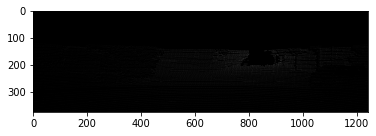

In [87]:
plt.imshow(depth_gt, 'gray')